**Chapter 19 – Reinforcement Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 19._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/19_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/19_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

Are we using Colab or Kaggle?

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

If using Colab, the Box2D and Stable-Baselines3 library are not pre-installed so we must install them manually. In Kaggle, Box2D is not preinstalled either, but Stable-Baselines3 and gymnasium are preinstalled, but too old, so we must update them.

In [3]:
if IS_COLAB:
    %pip uninstall -qy gym
    %pip install -qU Box2D stable_baselines3

if IS_KAGGLE:
    %pip uninstall -qy gym
    %pip install -qU gymnasium
    %pip install -qU Box2D stable_baselines3

We also need PyTorch ≥ 2.6.0:

In [4]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [6]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. Since this notebook contains animations, we also import `matplotlib.animation` and configure the animations to use JS+HTML.

In [7]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Lastly, let's load the `tensorboard` extension, which we will use in the PPO section below.

In [8]:
%load_ext tensorboard

# Introduction to Gymnasium

In [9]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=1000)

In [10]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [11]:
# extra code – shows the specification for the CartPole-v1 environment

envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [12]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [13]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [14]:
info

{}

In [15]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

/Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(400, 600, 3)

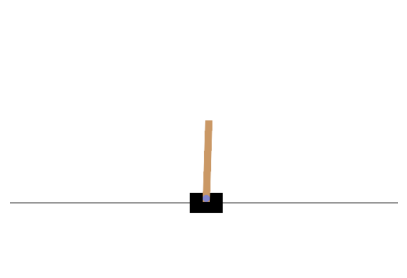

In [16]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [17]:
env.action_space

Discrete(2)

In [18]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [19]:
reward, done, truncated, info

(1.0, False, False, {})

In [20]:
if done or truncated:
    obs, info = env.reset()

# A simple hard-coded policy

In [21]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1  # go left if leaning left, otherwise go right

totals = []
for episode in range(500):
    total_rewards = 0
    obs, info = env.reset(seed=episode)
    while True:  # no risk of infinite loop: will be truncated after 1000 steps
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        total_rewards += reward
        if done or truncated:
            break

    totals.append(total_rewards)

In [22]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [23]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array",
                   max_episode_steps=1000)
    obs, info = env.reset(seed=seed)
    while True:
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

In [24]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 5), nn.ReLU(), nn.Linear(5, 1))

    def forward(self, state):
        return self.net(state)

In [25]:
def choose_action(model, obs):
    state = torch.as_tensor(obs)
    logit = model(state)
    dist = torch.distributions.Bernoulli(logits=logit)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return int(action.item()), log_prob

In [26]:
# extra code – a function that creates an animation for a given policy model

torch.manual_seed(42)
model = PolicyNetwork()
model.eval()

def neural_net_policy(obs):
    with torch.no_grad():
        action, _ = choose_action(model, obs)
        return action

show_one_episode(neural_net_policy)

# Policy Gradients

## REINFORCE

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [27]:
def compute_returns(rewards, discount_factor):
    returns = rewards[:]  # copy the rewards
    for step in range(len(returns) - 1, 0, -1):
        returns[step - 1] += returns[step] * discount_factor

    return torch.tensor(returns)

In [28]:
compute_returns([10, 0, -50], discount_factor=0.8)

tensor([-22., -40., -50.])

In [29]:
def run_episode(model, env, seed=None):
    log_probs, rewards = [], []
    obs, info = env.reset(seed=seed)
    while True:  # the environment will truncate the episode if it is too long
        action, log_prob = choose_action(model, obs)
        obs, reward, done, truncated, _info = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        if done or truncated:
            return log_probs, rewards

In [30]:
def train_reinforce(model, optimizer, env, n_episodes, discount_factor):
    for episode in range(n_episodes):
        seed = torch.randint(0, 2**32, size=()).item()
        log_probs, rewards = run_episode(model, env, seed=seed)
        returns = compute_returns(rewards, discount_factor)
        std_returns = (returns - returns.mean()) / (returns.std() + 1e-7)
        losses = [-logp * rt for logp, rt in zip(log_probs, std_returns)]
        loss = torch.cat(losses).sum()
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
        print(f"\rEpisode {episode + 1}, Reward: {sum(rewards):.2f}", end=" ")

In [31]:
torch.manual_seed(42)
model = PolicyNetwork()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.06)
train_reinforce(model, optimizer, env, n_episodes=200, discount_factor=0.95)

Episode 200, Reward: 1000.00 


In [32]:
show_one_episode(neural_net_policy)

# Extra Material – Markov Chains

The following transition probabilities correspond to the Markov Chain represented in Figure 19–7. Let's run this stochastic process a few times to see what it looks like:

In [33]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


# Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [34]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

In [35]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [36]:
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

In [37]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [38]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1])

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2. If you try again with a discount factor of 0.95 instead of 0.90, you will find that the optimal action for state s1 becomes a2. This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [39]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [40]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [41]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [42]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

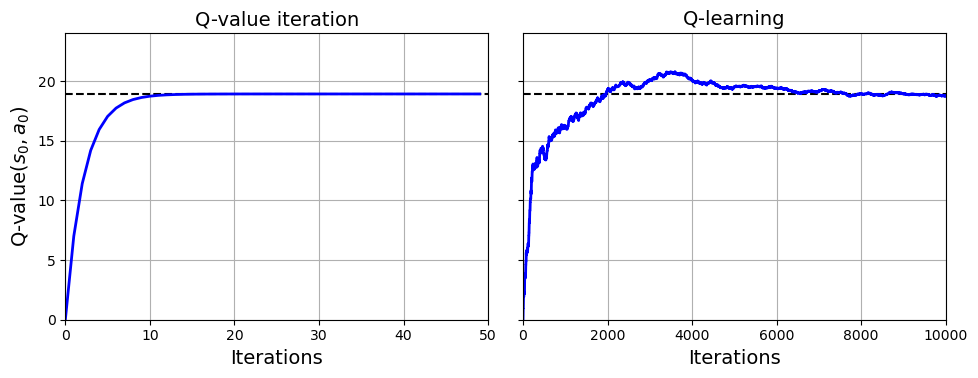

In [43]:
# extra code – this cell generates Figure 19–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-value iteration", fontsize=14)
axes[1].set_title("Q-learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

plt.show()

# Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [44]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 32), nn.ReLU(),
                                 nn.Linear(32, 32), nn.ReLU(),
                                 nn.Linear(32, 2))

    def forward(self, state):
        return self.net(state)

In [45]:
def choose_dqn_action(model, obs, epsilon=0.0):
        if torch.rand(()) < epsilon:  # epsilon greedy policy
            return torch.randint(2, size=()).item()
        else:
            state = torch.as_tensor(obs)
            Q_values = model(state)
            return Q_values.argmax().item()  # optimal according to the DQN

We will also need a replay buffer. It will contain the agent's experiences. Each experience will be represented as a tuple with six elements: (state, action, reward, next_state, done, truncated).

Let's also create a function to sample experiences from the replay buffer. It will return a tuple containing a tensor for each of the six fields:

In [46]:
def sample_experiences(replay_buffer, batch_size):
    indices = torch.randint(len(replay_buffer), size=[batch_size])
    batch = [replay_buffer[index] for index in indices.tolist()]
    return [to_tensor([exp[index] for exp in batch]) for index in range(6)]

def to_tensor(data):
    array = np.stack(data)
    dtype = torch.float32 if array.dtype == np.float64 else None
    return torch.as_tensor(array, dtype=dtype)

**Note**: for very large replay buffers (e.g., 100,000 or more), you may want to use a circular buffer instead, as random access time will be O(1) instead of O(N). Or you can check out DeepMind's [Reverb library](https://github.com/deepmind/reverb).

In [47]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_length):
        self.data = [None] * max_length
        self.max_length = max_length
        self.index = 0
        self.length = 0

    def append(self, obj):
        self.data[self.index] = obj
        self.length = min(self.length + 1, self.max_length)
        self.index = (self.index + 1) % self.max_length

    def __getitem__(self, index):
        if index < 0 or index >= self.length:
            raise IndexError(f"replay buffer index out of range: {index}")
        return self.data[index]

    def __len__(self):
        return self.length

buff = ReplayBuffer(max_length=4)
for i in range(8):
    buff.append(i)
    print(f"Length: {len(buff)}, data: {buff.data}")

Length: 1, data: [0, None, None, None]
Length: 2, data: [0, 1, None, None]
Length: 3, data: [0, 1, 2, None]
Length: 4, data: [0, 1, 2, 3]
Length: 4, data: [4, 1, 2, 3]
Length: 4, data: [4, 5, 2, 3]
Length: 4, data: [4, 5, 6, 3]
Length: 4, data: [4, 5, 6, 7]


Now we can create a function that will use the DQN to play one step, and record its experience in the replay buffer:

In [48]:
def play_and_record_episode(model, env, replay_buffer, epsilon, seed=None):
    obs, _info = env.reset(seed=seed)
    total_rewards = 0
    model.eval()
    with torch.no_grad():
        while True:
            action = choose_dqn_action(model, obs, epsilon)
            next_obs, reward, done, truncated, _info = env.step(action)
            experience = (obs, action, reward, next_obs, done, truncated)
            replay_buffer.append(experience)
            total_rewards += reward
            if done or truncated:
                return total_rewards
            obs = next_obs

Lastly, let's create a function that will sample some experiences from the replay buffer and perform a training step:

In [49]:
def dqn_training_step(model, optimizer, criterion, replay_buffer, batch_size,
                      discount_factor):
    experiences = sample_experiences(replay_buffer, batch_size)
    state, action, reward, next_state, done, truncated = experiences
    with torch.inference_mode():
        next_Q_value = model(next_state)

    max_next_Q_value, _ = next_Q_value.max(dim=1)
    running = (~(done | truncated)).float()  # 0 if s' is over, 1 if running
    target_Q_value = reward + running * discount_factor * max_next_Q_value
    all_Q_values = model(state)
    Q_value = all_Q_values.gather(dim=1, index=action.unsqueeze(1))
    loss = criterion(Q_value, target_Q_value.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

And now, let's train the model!

In [50]:
from collections import deque

def train_dqn(model, env, replay_buffer, optimizer, criterion, n_episodes=800,
              warmup=30, batch_size=32, discount_factor=0.95):
    totals = []
    for episode in range(n_episodes):
        epsilon = max(1 - episode / 500, 0.01)
        seed = torch.randint(0, 2**32, size=()).item()
        total_rewards = play_and_record_episode(model, env, replay_buffer,
                                                epsilon, seed=seed)
        print(f"\rEpisode: {episode + 1}, Rewards: {total_rewards}", end=" ")
        totals.append(total_rewards)
        if episode >= warmup:
            dqn_training_step(model, optimizer, criterion, replay_buffer,
                              batch_size, discount_factor)
    return totals

torch.manual_seed(42)
dqn = DQN()
optimizer = torch.optim.NAdam(dqn.parameters(), lr=0.03)
mse = nn.MSELoss()
replay_buffer = deque(maxlen=100_000)
totals = train_dqn(dqn, env, replay_buffer, optimizer, mse)

Episode: 800, Rewards: 1000.0 

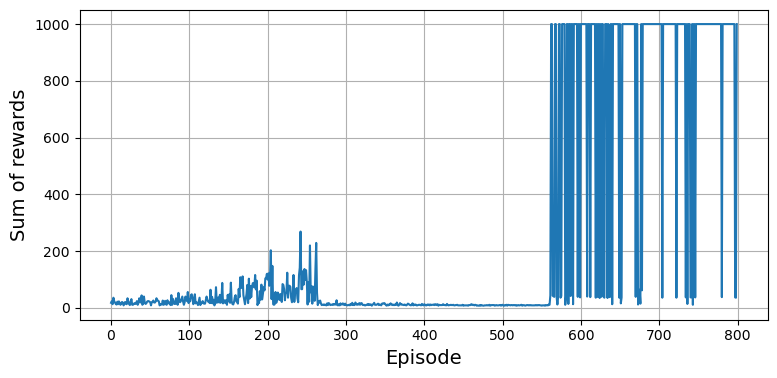

In [51]:
# extra code – this cell generates Figure 19–10
plt.figure(figsize=(8, 4))
plt.plot(totals)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)

plt.show()

In [52]:
# extra code – shows an animation of the trained DQN playing one episode

torch.manual_seed(42)
dqn.eval()

def dqn_policy(obs):
    with torch.no_grad():
        return choose_dqn_action(dqn, obs)

show_one_episode(dqn_policy)

That's a very stable CartPole! 😀

# Actor-Critic

In [53]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(4, 32), nn.ReLU(),
                                  nn.Linear(32, 32), nn.ReLU())
        self.actor_head = nn.Linear(32, 1)  # outputs action logits
        self.critic_head = nn.Linear(32, 1)  # outputs state values

    def forward(self, state):
        features = self.body(state)
        return self.actor_head(features), self.critic_head(features)

In [54]:
def choose_action_and_evaluate(model, obs):
    state = torch.as_tensor(obs)
    logit, state_value = model(state)
    dist = torch.distributions.Bernoulli(logits=logit)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return int(action.item()), log_prob, state_value

In [55]:
def ac_training_step(optimizer, criterion, state_value, target_value, log_prob,
                     critic_weight):
    td_error = target_value - state_value
    actor_loss = -log_prob * td_error.detach()
    critic_loss = criterion(state_value, target_value)
    loss = actor_loss + critic_weight * critic_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [56]:
def get_target_value(model, next_obs, reward, done, truncated, discount_factor):
    with torch.inference_mode():
        _, _, next_state_value = choose_action_and_evaluate(model, next_obs)

    running = 0.0 if (done or truncated) else 1.0
    target_value = reward + running * discount_factor * next_state_value
    return target_value

In [57]:
def run_episode_and_train(model, optimizer, criterion, env, discount_factor,
                          critic_weight, seed=None):
    obs, _info = env.reset(seed=seed)
    total_rewards = 0    
    while True:
        action, log_prob, state_value = choose_action_and_evaluate(model, obs)
        next_obs, reward, done, truncated, _info = env.step(action)
        target_value = get_target_value(model, next_obs, reward, done,
                                        truncated, discount_factor)
        ac_training_step(optimizer, criterion, state_value, target_value,
                         log_prob, critic_weight)
        total_rewards += reward
        if done or truncated:
            return total_rewards
        obs = next_obs

In [58]:
def train_actor_critic(model, optimizer, criterion, env, n_episodes=400,
                       discount_factor=0.95, critic_weight=0.3):
    totals = []
    model.train()
    for episode in range(n_episodes):
        seed = torch.randint(0, 2**32, size=()).item()
        total_rewards = run_episode_and_train(model, optimizer, criterion, env,
                                              discount_factor, critic_weight,
                                              seed=seed)
        totals.append(total_rewards)
        print(f"\rEpisode: {episode + 1}, Rewards: {total_rewards}", end=" ")

    return totals

In [59]:
torch.manual_seed(42)
ac_model = ActorCritic()
optimizer = torch.optim.NAdam(ac_model.parameters(), lr=1.1e-3)
criterion = nn.MSELoss()
totals = train_actor_critic(ac_model, optimizer, criterion, env)

Episode: 400, Rewards: 1000.0 

In [60]:
# extra code – shows an animation of the trained DQN playing one episode

torch.manual_seed(42)
ac_model.eval()

def actor_critic_policy(obs):
    with torch.no_grad():
        action, _, _ = choose_action_and_evaluate(ac_model, obs)
        return action

show_one_episode(actor_critic_policy)

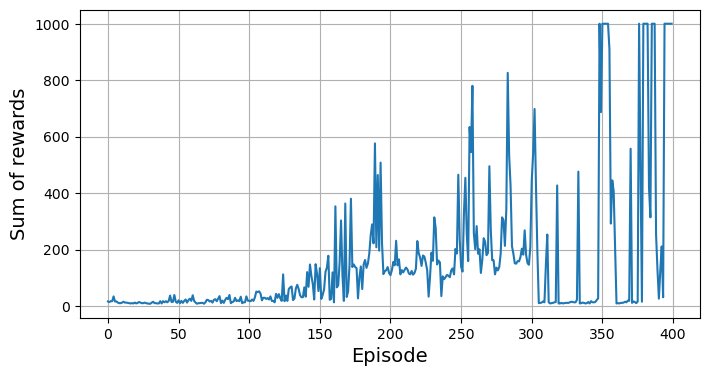

In [61]:
# extra code

plt.figure(figsize=(8, 4))
plt.plot(totals)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

# PPO

In [62]:
import ale_py

ale = ale_py.ALEInterface()

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]


If you are running this notebook on your own machine and you used Anaconda to install gymnasium-atari, then the package does _not_ include the Atari ROMs, so you must install them manually. For this, you can use the AutoROM package like this:

In [63]:
gymnasium_atari_was_installed_using_anaconda = False
if gymnasium_atari_was_installed_using_anaconda:
    %pip install -qU AutoROM
    from pathlib import Path
    from AutoROM import main as autorom
    
    autorom(accept_license=True, source_file=None,  # you accept the Atari license
            install_dir=Path(ale_py.roms.__path__[0]), quiet=False)

In [64]:
from stable_baselines3.common.env_util import make_atari_env

envs = make_atari_env("BreakoutNoFrameskip-v4", n_envs=4, seed=42)
obs = envs.reset()  # a 4 ✕ 84 ✕ 84 ✕ 1 NumPy array (note: no info dict)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -155179565
A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1805196897
A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  R

<<18 more lines>>


  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1625411987
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 2044548950
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1426356153
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway I

In [65]:
obs.shape

(4, 84, 84, 1)

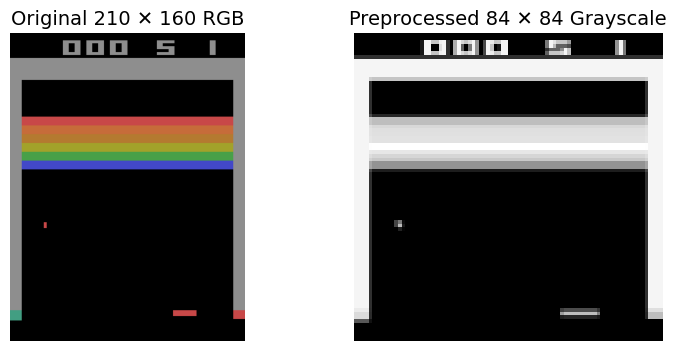

In [66]:
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title("Original 210 ✕ 160 RGB")
plt.imshow(envs.get_images()[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Preprocessed 84 ✕ 84 Grayscale")
plt.imshow(obs[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()

In [67]:
from stable_baselines3.common.vec_env import VecFrameStack

envs_stacked = VecFrameStack(envs, n_stack=4)
obs = envs_stacked.reset()  # returns a 4 ✕ 84 ✕ 84 ✕ 4 NumPy array

In [68]:
from stable_baselines3 import PPO

tensorboard_logdir = "my_ppo_breakout_tensorboard"  # path to the log directory

ppo_model = PPO("CnnPolicy", envs_stacked, device=device, learning_rate=2.5e-4,
                batch_size=256, n_steps=256, n_epochs=4, clip_range=0.1,
                vf_coef=0.5, ent_coef=0.01, gamma=0.99, verbose=0,
                tensorboard_log=tensorboard_logdir)

In [69]:
ppo_model.policy

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

In [70]:
%tensorboard --logdir={tensorboard_logdir} --port 6006

In [71]:
from stable_baselines3.common.callbacks import CheckpointCallback

cb = CheckpointCallback(save_freq=100_000, save_path="my_checkpoints",
                        name_prefix="breakout")
ppo_model.learn(total_timesteps=200_000, progress_bar=True, callback=cb)
ppo_model.save("my_ppo_agent_breakout")  # save the final model

Output()

I ran this code for 30 million steps so you won't have to: just run the following cell to download the trained model.

In [72]:
import urllib.request

data_root = "https://raw.githubusercontent.com/ageron/data/refs/heads/main"
filename = "ppo_agent_breakout.zip"
urllib.request.urlretrieve(f"{data_root}/{filename}", f"my_{filename}")

('my_ppo_agent_breakout.zip', <http.client.HTTPMessage at 0x3fc01b5f0>)

In [73]:
ppo_model = PPO.load("my_ppo_agent_breakout")  # or load the best checkpoint
eval_env = make_atari_env("BreakoutNoFrameskip-v4", n_envs=1, seed=42)
eval_stacked = VecFrameStack(eval_env, n_stack=4)
frames = []
obs = eval_stacked.reset()
for _ in range(5000):  # some limit in case the agent never loses
    frames.append(eval_stacked.render())
    action, _ = ppo_model.predict(obs, deterministic=True) # for reproducibility
    obs, reward, done, info = eval_stacked.step(action)
    if done[0]:  # note: there's no `truncated`
        break

eval_stacked.close()

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -393043141
Game console created:
  ROM file:  /Users/ageron/mamba/envs/homlp/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1625411987


In [74]:
plot_animation(frames)

Note: I also trained an agent for the Centipede game: to try it out, replace "breakout" (or "Breakout") with "centipede" (or "Centipede") in the last three cells and run them.

I hope you enjoyed this notebook!

# Exercise Solutions

. How would you define reinforcement learning? How is it different from regular supervised or unsupervised learning?
. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are some possible actions? What are the rewards?
. What is the discount factor? Can the optimal policy change if you modify the discount factor?
. How do you measure the performance of a reinforcement learning agent?
. What is the credit assignment problem? When does it occur? How can you alleviate it?
. What is the point of using a replay buffer?
. What is an off-policy RL algorithm? What are the benefits?


## 1. to 7.

1. Reinforcement Learning is an area of Machine Learning aimed at creating agents capable of taking actions in an environment in a way that maximizes rewards over time. There are many differences between RL and regular supervised and unsupervised learning. Here are a few:
    * In supervised and unsupervised learning, the goal is generally to find patterns in the data and use them to make predictions. In Reinforcement Learning, the goal is to find a good policy.
    * Unlike in supervised learning, the agent is not explicitly given the "right" answer. It must learn by trial and error.
    * Unlike in unsupervised learning, there is a form of supervision, through rewards. We do not tell the agent how to perform the task, but we do tell it when it is making progress or when it is failing.
    * A Reinforcement Learning agent needs to find the right balance between exploring the environment, looking for new ways of getting rewards, and exploiting sources of rewards that it already knows. In contrast, supervised and unsupervised learning systems generally don't need to worry about exploration; they just feed on the training data they are given.
    * In supervised and unsupervised learning, training instances are typically independent (in fact, they are generally shuffled). In Reinforcement Learning, consecutive observations are generally _not_ independent. An agent may remain in the same region of the environment for a while before it moves on, so consecutive observations will be very correlated. In some cases a replay buffer (memory) is used to ensure that the training algorithm gets fairly independent observations.
2. Here are a few possible applications of Reinforcement Learning, other than those mentioned in Chapter 19:
    * Music personalization: The environment is a user's personalized web radio. The agent is the software deciding what song to play next for that user. Its possible actions are to play any song in the catalog (it must try to choose a song the user will enjoy) or to play an advertisement (it must try to choose an ad that the user will be interested in). It gets a small reward every time the user listens to a song, a larger reward every time the user listens to an ad, a negative reward when the user skips a song or an ad, and a very negative reward if the user leaves.
    * Marketing: The environment is your company's marketing department. The agent is the software that defines which customers a mailing campaign should be sent to, given their profile and purchase history (for each customer it has two possible actions: send or don't send). It gets a negative reward for the cost of the mailing campaign, and a positive reward for estimated revenue generated from this campaign.
    * Product delivery: Let the agent control a fleet of delivery trucks, deciding what they should pick up at the depots, where they should go, what they should drop off, and so on. It will get positive rewards for each product delivered on time, and negative rewards for late deliveries.
3. When estimating the value of an action, Reinforcement Learning algorithms typically sum all the rewards that this action led to, giving more weight to immediate rewards and less weight to later rewards (considering that an action has more influence on the near future than on the distant future). To model this, a discount factor is typically applied at each time step. For example, with a discount factor of 0.9, a reward of 100 that is received two time steps later is counted as only 0.9<sup>2</sup> × 100 = 81 when you are estimating the value of the action. You can think of the discount factor as a measure of how much the future is valued relative to the present: if it is very close to 1, then the future is valued almost as much as the present; if it is close to 0, then only immediate rewards matter. Of course, this impacts the optimal policy tremendously: if you value the future, you may be willing to put up with a lot of immediate pain for the prospect of eventual rewards, while if you don't value the future, you will just grab any immediate reward you can find, never investing in the future.
4. To measure the performance of a Reinforcement Learning agent, you can simply sum up the rewards it gets. In a simulated environment, you can run many episodes and look at the total rewards it gets on average (and possibly look at the min, max, standard deviation, and so on).
5. The credit assignment problem is the fact that when a Reinforcement Learning agent receives a reward, it has no direct way of knowing which of its previous actions contributed to this reward. It typically occurs when there is a large delay between an action and the resulting reward (e.g., during a game of Atari's _Pong_, there may be a few dozen time steps between the moment the agent hits the ball and the moment it wins the point). One way to alleviate it is to provide the agent with shorter-term rewards, when possible. This usually requires prior knowledge about the task. For example, if we want to build an agent that will learn to play chess, instead of giving it a reward only when it wins the game, we could give it a reward every time it captures one of the opponent's pieces.
6. An agent can often remain in the same region of its environment for a while, so all of its experiences will be very similar for that period of time. This can introduce some bias in the learning algorithm. It may tune its policy for this region of the environment, but it will not perform well as soon as it moves out of this region. To solve this problem, you can use a replay buffer; instead of using only the most immediate experiences for learning, the agent will learn based on a buffer of its past experiences, recent and not so recent (perhaps this is why we dream at night: to replay our experiences of the day and better learn from them?).
7. An off-policy RL algorithm learns the value of the optimal policy (i.e., the sum of discounted rewards that can be expected for each state if the agent acts optimally) while the agent follows a different policy. Q-Learning is a good example of such an algorithm. In contrast, an on-policy algorithm learns the value of the policy that the agent actually executes, including both exploration and exploitation.
8. A model-based RL algorithm includes a model of the environment, which it uses to predict future states and rewards. This makes it possible to plan ahead by simulating the outcomes of potential actions or sequences of actions. A good example is MuZero, which learns such a model and uses Monte-Carlo Tree Search (MCTS) for planning.

## 8.
_Exercise: Use policy gradients to solve Gymnasium's LunarLander-v2 environment._

## Work in progress

I'm working on the exercise solutions, hoping to finish them by December 2025. Thanks for your patience!

## 9.
_Exercise: Solve the BipedalWalker-v3 environment using the RL algorithm of your choice._

## Work in progress

I'm working on the exercise solutions, hoping to finish them by December 2025. Thanks for your patience!

## 10.
_Exercise: If you have about $100 to spare, you can purchase a Raspberry Pi 3 plus some cheap robotics components, install PyTorch on the Pi, and go wild! Start with simple goals, like making the robot turn around to find the brightest angle (if it has a light sensor) or the closest object (if it has a sonar sensor), and move in that direction. Then you can start using deep learning: for example, if the robot has a camera, you can try to implement an object detection algorithm so it detects people and moves toward them. You can also try to use RL to make the agent learn on its own how to use the motors to achieve that goal. Have fun!_

This one is up to you! The world is your oyster. 😄